In [1]:
from IPython.display import Image
from IPython.core.display import HTML 

import warnings
warnings.filterwarnings('ignore')

## [DSO] Machine Learning Seminar Vol.3
2020-03-xx  
SKUE

In [231]:
Image(url="https://image.yodobashi.com/product/100/000/009/002/935/105/100000009002935105_10204.jpg")

## Chapter4：データ前処理 - よりよいトレーニングセットの構築
+ 欠測データへの対処
+ カテゴリデータの処理
+ データセットをトレーニングデータセットとテストデータセットに分割する
+ 特徴量の尺度を揃える
+ 有益な特徴量の選択
+ ランダムフォレストで特徴量の重要度にアクセスする

In [3]:
import pandas as pd
from io import StringIO # StringIOは、文字列にファイルオブジェクトのインタフェースを与えることができるライブラリです。

csv_data = '''A,B,C,D
                        1.0,2.0,3.0,4.0
                        5.0,6.0,,8.0
                        10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [4]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

In [5]:
df.dropna()

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [7]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [6]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


In [8]:
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [9]:
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [13]:
df.dropna(thresh=1)

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [14]:
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


In [17]:
df.dropna(subset=['A'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [16]:
df.dropna(subset=['D'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0


### 欠損値を補完する

In [18]:
from sklearn.preprocessing import Imputer

# 平均値での補完
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)

imr = imr.fit(df.values)

imputed_data = imr.transform(df.values)

imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

他にも欠損値補完の方法があるので、扱いたい。

### カテゴリデータの処理

In [27]:
import pandas as pd

df = pd.DataFrame([
    ['green', 'M', 10.1, 'class1'],
    ['red', 'L', 13.5, 'class2'],
    ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


In [28]:
size_mapping = {'XL':3,
                              'L':2,
                              'M':1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [29]:
size_mapping.items()

dict_items([('M', 1), ('L', 2), ('XL', 3)])

In [30]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
inv_size_mapping

{1: 'M', 2: 'L', 3: 'XL'}

In [31]:
df['size']

0    1
1    2
2    3
Name: size, dtype: int64

In [32]:
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### クラスラベルのエンコーディング

In [33]:
import numpy as np

class_mapping = {label:idx for idx, label in enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

In [34]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


In [35]:
inv_class_mapping = {v: k for k,v in class_mapping.items()}

df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


In [36]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()

y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

In [37]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### 名義特徴量でのone-hotエンコーディング

In [39]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()

X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

In [40]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [41]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [43]:
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


In [44]:
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()[:, 1:]

array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

### データセットをトレーニングデータセットとテストデータセットに分割する

In [46]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [48]:
df_wine.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [49]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 
                                    'Flavanoids', 'Nonflavanoid phenols','Pronthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                                    'Proline']

In [50]:
print('Class labels', np.unique(df_wine['Class label']))

Class labels [1 2 3]


In [51]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Pronthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [52]:
from sklearn.model_selection import train_test_split

In [54]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

### 特徴量の尺度を揃える

In [55]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [59]:
ex = np.array([0, 1, 2, 3, 4, 5])
print('standardized:' ,(ex - ex.mean())/ex.std())

print('normalized:', (ex - ex.min()) / (ex.max() - ex.min() ) )

standardized: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]
normalized: [0.  0.2 0.4 0.6 0.8 1. ]


In [60]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

### 有益な特徴量の選択
+ 多くのトレーニングデータを集める
+ 正則化を通じて複雑さにペナルティを科す
+ パラメータの数が少ない、より単純なモデルを選択する
+ データの次元の数を減らす

In [61]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [62]:
lr = LogisticRegression(penalty='l1', C=1.0)
lr.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [63]:
print('Training accuracy:', lr.score(X_train_std, y_train))

Training accuracy: 1.0


In [64]:
print('Test accuracy:', lr.score(X_test_std, y_test))

Test accuracy: 1.0


In [65]:
lr.intercept_

array([-1.26409632, -1.21564327, -2.37005481])

In [66]:
lr.coef_

array([[ 1.24662193,  0.18053359,  0.74637521, -1.1643769 ,  0.        ,
         0.        ,  1.158131  ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.5604125 ,  2.50836329],
       [-1.53895274, -0.38579653, -0.99505143,  0.36315789, -0.05911634,
         0.        ,  0.66695006,  0.        ,  0.        , -1.93206826,
         1.23792702,  0.        , -2.23347704],
       [ 0.13579033,  0.16827211,  0.35716566,  0.        ,  0.        ,
         0.        , -2.43833215,  0.        ,  0.        ,  1.56389641,
        -0.81923385, -0.49186372,  0.        ]])

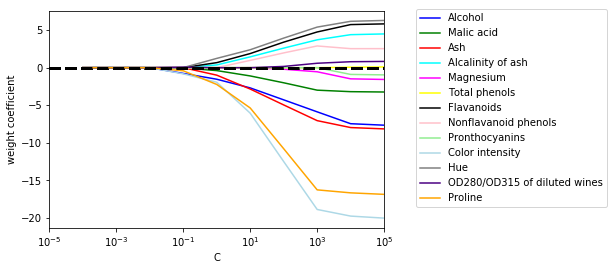

In [72]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black',
                 'pink', 'lightgreen', 'lightblue', 'gray', 'indigo', 'orange']
weights, params = [], []

for c in np.arange(-4., 6.):
    lr = LogisticRegression(penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights= np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column], label=df_wine.columns[column+1],
                    color=color)
    plt.axhline(0, color='black', linestyle='--', linewidth=3)
    plt.xlim([10**(-5), 10**5])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', bbox_to_anchor=(1.38, 1.03), ncol=1, fancybox=True)

### 逐次特徴量選択システム

In [86]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split # 129pのコードはタイポ
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                            test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator) # Constructs a new estimator with the same parameters.
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r=dim - 1): # 長さrのタプル列、ソートされた順で重複なし
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            
            dim -= 1
            self.scores_.append(scores[best])
            
        self.k_scores_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:,indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [87]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=5)
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

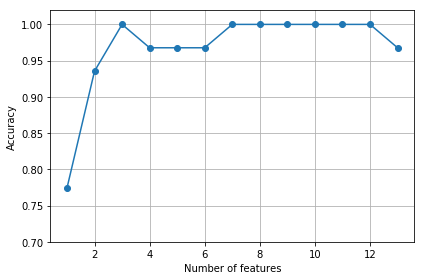

In [89]:
k_feat = [len(k) for k in sbs.subsets_ ]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

In [90]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [91]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))

print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [94]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))

print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


### ランダムフォレストで特徴量の重要度にアクセスする
+ 不純度の平均的な減少を重要度として測っている。

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Pronthocyanins                 0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


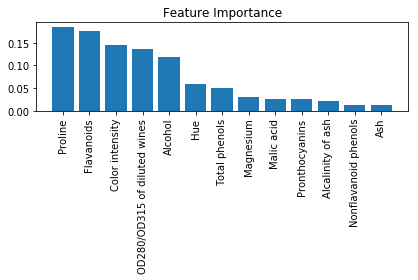

In [98]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

一定の閾値以上の変数重要度の特徴量だけを選ぶ

In [102]:
from sklearn.feature_selection import SelectFromModel

sfm =SelectFromModel(forest, threshold=0.1, prefit=True)

X_selected = sfm.transform(X_train)
print('Number of samples that meet this criterion:', X_selected.shape[0])

for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]],
                                                                   importances[indices[f]]))

Number of samples that meet this criterion: 124
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
